In [12]:

# Install all PyTorch Geometric dependencies (CPU version)
!pip install --upgrade pip setuptools wheel
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch_geometric
!pip install scikit-learn
!pip install matplotlib


Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


In [50]:
# Import libraries and load data
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
import copy

# Load train, val, and test sets
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

# Wrap in data loaders for batch training
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of nodes in first graph: {train_dataset[0].num_nodes}")
print(f"Feature shape: {train_dataset[0].x.shape}")
print(f"Labels shape: {train_dataset[0].y.shape}")


Number of training graphs: 20
Number of nodes in first graph: 1767
Feature shape: torch.Size([1767, 50])
Labels shape: torch.Size([1767, 121])


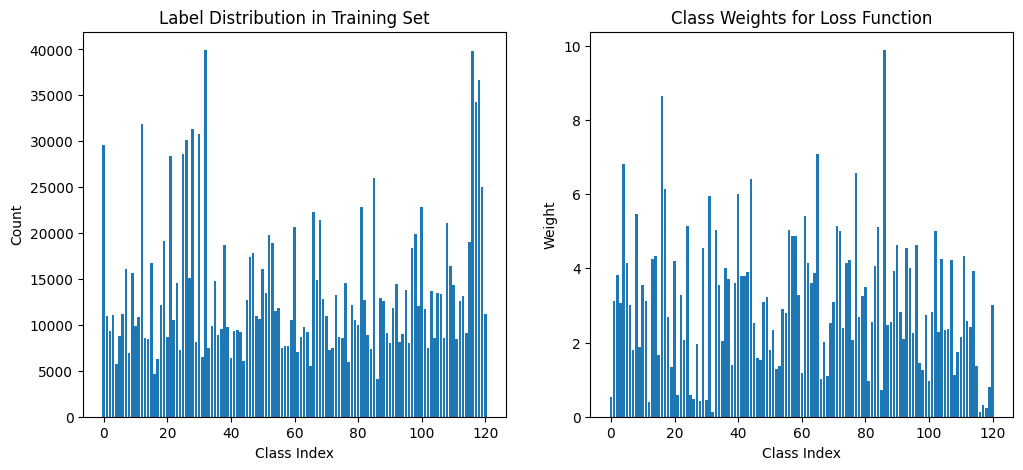

In [34]:
#Compute and graph class-wise positive label counts and weights
def compute_pos_weights(loader):
    total_pos = torch.zeros(train_dataset.num_classes)
    total_count = 0
    for batch in loader:
        total_pos += batch.y.sum(dim=0)
        total_count += batch.y.size(0)
    neg = total_count - total_pos
    pos_weight = neg / (total_pos + 1e-6)
    return total_pos, pos_weight

label_distribution, class_weights = compute_pos_weights(train_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

# Plot label distribution and class weights
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(range(len(label_distribution)), label_distribution.numpy())
axs[0].set_title("Label Distribution in Training Set")
axs[0].set_xlabel("Class Index")
axs[0].set_ylabel("Count")

axs[1].bar(range(len(class_weights)), class_weights.cpu().numpy())
axs[1].set_title("Class Weights for Loss Function")
axs[1].set_xlabel("Class Index")
axs[1].set_ylabel("Weight")
plt.show()

In [53]:
# Training curve function
def plot_graphs(train_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label='Validation F1', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 over Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# GraphSAGE model definition
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.conv2 = SAGEConv(hidden_feats, out_feats)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
# DeepGraphSAGE model definition
class DeepGraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(DeepGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.bn1 = nn.BatchNorm1d(hidden_feats)

        self.conv2 = SAGEConv(hidden_feats, hidden_feats)
        self.bn2 = nn.BatchNorm1d(hidden_feats)

        self.conv3 = SAGEConv(hidden_feats, hidden_feats)
        self.bn3 = nn.BatchNorm1d(hidden_feats)

        self.conv4 = SAGEConv(hidden_feats, out_feats)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)  # NOTE: no sigmoid here
        return x

In [45]:
# GAT model definition
class GAT(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, heads=4):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_feats, hidden_feats, heads=heads)
        self.gat2 = GATConv(hidden_feats * heads, hidden_feats, heads=heads)
        self.gat3 = GATConv(hidden_feats * heads, out_feats, heads=1)
        self.activation = nn.ELU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.gat2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.gat3(x, edge_index)
        return torch.sigmoid(x)

In [ ]:
# Evaluation helper
def evaluate(model, loader):
    model.eval()
    total_f1 = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = torch.sigmoid(model(batch.x, batch.edge_index))  # Apply sigmoid here
            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_f1 += f1
    return total_f1 / len(loader)

def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=15):
    train_losses = []
    val_f1_scores = []

    best_val_f1 = 0
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_f1 = evaluate(model, val_loader)

        train_losses.append(avg_loss)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}, Val F1: {val_f1:.4f}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, val_f1_scores

Epoch 1/100, Loss: 0.9689, Val F1: 0.4771
Epoch 2/100, Loss: 0.9175, Val F1: 0.4803
Epoch 3/100, Loss: 0.8812, Val F1: 0.5243
Epoch 4/100, Loss: 0.8528, Val F1: 0.5502
Epoch 5/100, Loss: 0.8344, Val F1: 0.5604
Epoch 6/100, Loss: 0.8224, Val F1: 0.5546
Epoch 7/100, Loss: 0.8163, Val F1: 0.5400
Epoch 8/100, Loss: 0.8141, Val F1: 0.5647
Epoch 9/100, Loss: 0.8098, Val F1: 0.5725
Epoch 10/100, Loss: 0.8061, Val F1: 0.5516
Epoch 11/100, Loss: 0.8049, Val F1: 0.5682
Epoch 12/100, Loss: 0.8057, Val F1: 0.5816
Epoch 13/100, Loss: 0.8027, Val F1: 0.5560
Epoch 14/100, Loss: 0.8012, Val F1: 0.5617
Epoch 15/100, Loss: 0.8022, Val F1: 0.5864
Epoch 16/100, Loss: 0.7999, Val F1: 0.5649
Epoch 17/100, Loss: 0.7974, Val F1: 0.5724
Epoch 18/100, Loss: 0.7978, Val F1: 0.5765
Epoch 19/100, Loss: 0.7960, Val F1: 0.5700
Epoch 20/100, Loss: 0.7971, Val F1: 0.5883
Epoch 21/100, Loss: 0.7944, Val F1: 0.5604
Epoch 22/100, Loss: 0.7969, Val F1: 0.5533
Epoch 23/100, Loss: 0.7946, Val F1: 0.5815
Epoch 24/100, Loss: 

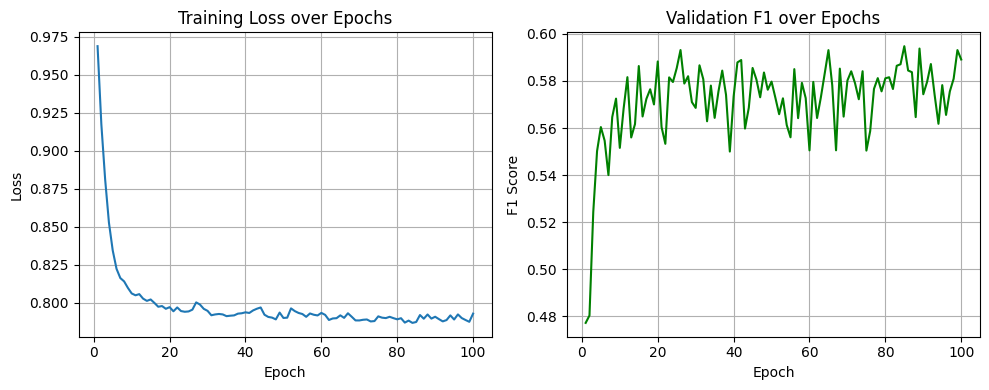

In [ ]:
# Run GraphSAGE 
# Init model, optimizer, loss
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)                # Changed from:  loss_fn = nn.BCELoss()

# Train
train_losses, val_f1_scores = train_model(model, train_loader, val_loader, optimizer, loss_fn)

# Final test evaluation
val_f1 = evaluate(model, val_loader)
test_f1 = evaluate(model, test_loader)
print(f"\nValidation F1: {val_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
plot_graphs(train_losses, val_f1_scores)


Epoch 1/100, Loss: 1.0142, Val F1: 0.4472
Epoch 2/100, Loss: 0.8947, Val F1: 0.3411
Epoch 3/100, Loss: 0.8502, Val F1: 0.3566
Epoch 4/100, Loss: 0.8223, Val F1: 0.4793
Epoch 5/100, Loss: 0.8031, Val F1: 0.4846
Epoch 6/100, Loss: 0.7849, Val F1: 0.5667
Epoch 7/100, Loss: 0.7643, Val F1: 0.5999
Epoch 8/100, Loss: 0.7412, Val F1: 0.5474
Epoch 9/100, Loss: 0.7297, Val F1: 0.6171
Epoch 10/100, Loss: 0.7170, Val F1: 0.6059
Epoch 11/100, Loss: 0.7032, Val F1: 0.6208
Epoch 12/100, Loss: 0.6994, Val F1: 0.6353
Epoch 13/100, Loss: 0.6880, Val F1: 0.6332
Epoch 14/100, Loss: 0.6733, Val F1: 0.6192
Epoch 15/100, Loss: 0.6739, Val F1: 0.6440
Epoch 16/100, Loss: 0.6529, Val F1: 0.6618
Epoch 17/100, Loss: 0.6462, Val F1: 0.6375
Epoch 18/100, Loss: 0.6414, Val F1: 0.6813
Epoch 19/100, Loss: 0.6521, Val F1: 0.6827
Epoch 20/100, Loss: 0.6316, Val F1: 0.6850
Epoch 21/100, Loss: 0.6269, Val F1: 0.6704
Epoch 22/100, Loss: 0.6403, Val F1: 0.6936
Epoch 23/100, Loss: 0.6267, Val F1: 0.6782
Epoch 24/100, Loss: 

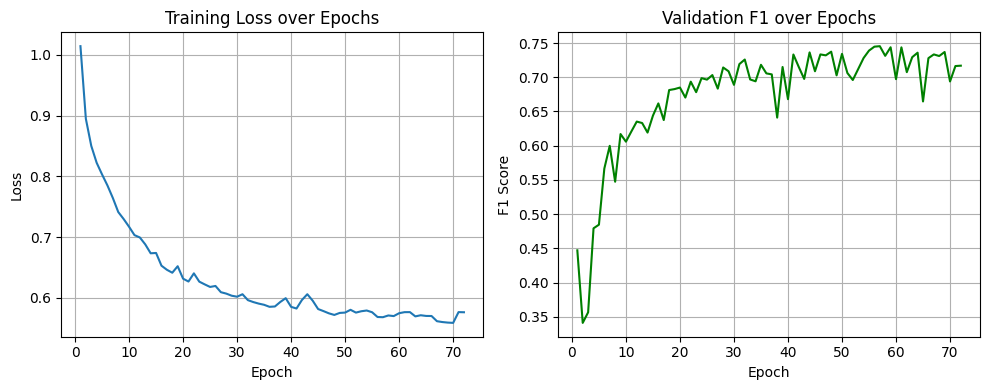

In [56]:
# Run DeepGraphSAGE
# Init
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepGraphSAGE(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))       # Changed from:  loss_fn = nn.BCELoss()

# Train
train_losses, val_f1_scores = train_model(model, train_loader, val_loader, optimizer, loss_fn)

# Validate and Test
val_f1 = evaluate(model, val_loader)
test_f1 = evaluate(model, test_loader)
print(f"\nValidation F1: {val_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
plot_graphs(train_losses, val_f1_scores)


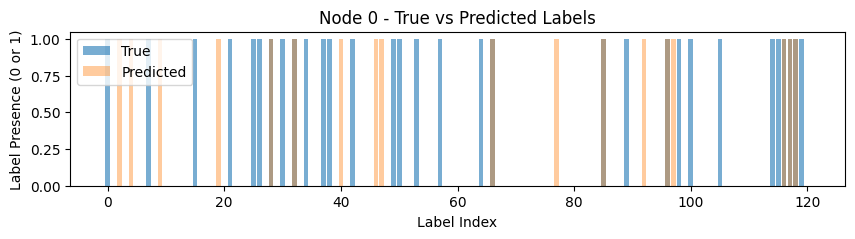

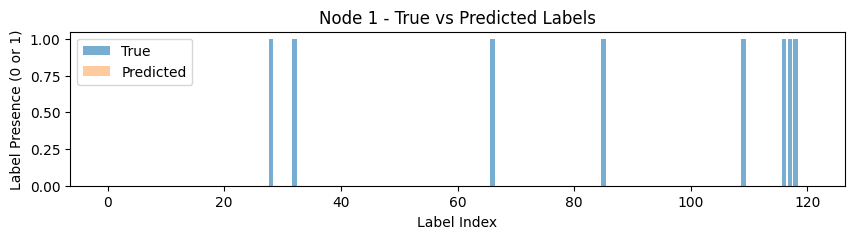

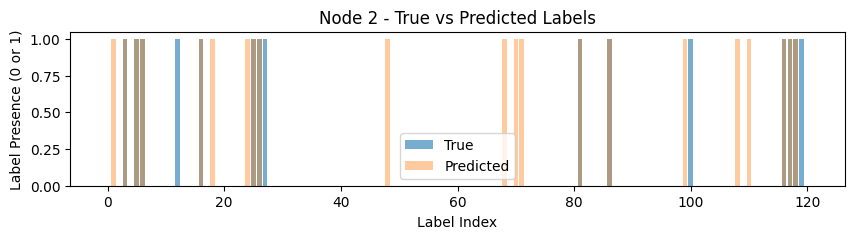

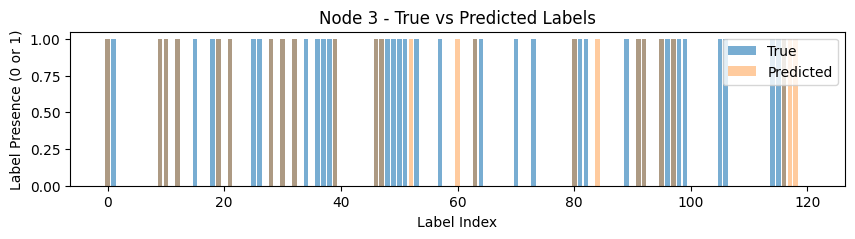

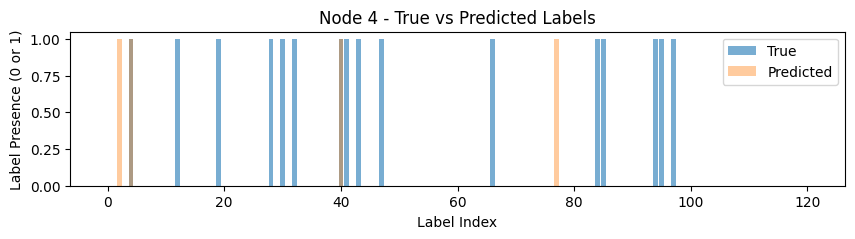

In [57]:
# Visualize predictions for the first graph in test set
model.eval()
sample = test_dataset[0].to(device)

with torch.no_grad():
    pred = model(sample.x, sample.edge_index)
    pred_bin = (pred > 0.5).float().cpu()

# Plot true vs predicted labels for first 5 nodes
num_nodes_to_plot = 5
for i in range(num_nodes_to_plot):
    plt.figure(figsize=(10, 2))
    plt.bar(range(out_feats), sample.y[i].cpu(), alpha=0.6, label='True')
    plt.bar(range(out_feats), pred_bin[i], alpha=0.4, label='Predicted')
    plt.title(f"Node {i} - True vs Predicted Labels")
    plt.xlabel("Label Index")
    plt.ylabel("Label Presence (0 or 1)")
    plt.legend()
    plt.show()


In [ ]:
# Run GAT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 256
model = GAT(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))       # Changed from:  loss_fn = nn.BCELoss()

# Train the GAT model
train_losses, val_f1_scores = train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100)

# Final test performance
val_f1 = evaluate(model, val_loader)
test_f1 = evaluate(model, test_loader)
print(f"\nValidation F1: {val_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
plot_graphs(train_losses, val_f1_scores)

Epoch 10/100, Loss: 0.5245, Train F1: 0.4725, Val F1: 0.5115
Epoch 20/100, Loss: 0.5262, Train F1: 0.4693, Val F1: 0.4640
Epoch 30/100, Loss: 0.5121, Train F1: 0.4980, Val F1: 0.4945
Epoch 40/100, Loss: 0.5037, Train F1: 0.5146, Val F1: 0.5517
Epoch 50/100, Loss: 0.5032, Train F1: 0.5113, Val F1: 0.5373
Epoch 60/100, Loss: 0.5035, Train F1: 0.5142, Val F1: 0.5318
Epoch 70/100, Loss: 0.5061, Train F1: 0.5090, Val F1: 0.5344
Epoch 80/100, Loss: 0.5030, Train F1: 0.5184, Val F1: 0.5614
Epoch 90/100, Loss: 0.4985, Train F1: 0.5251, Val F1: 0.4997
Epoch 100/100, Loss: 0.4979, Train F1: 0.5212, Val F1: 0.5386
🎯 Final Test Micro-F1: 0.5439


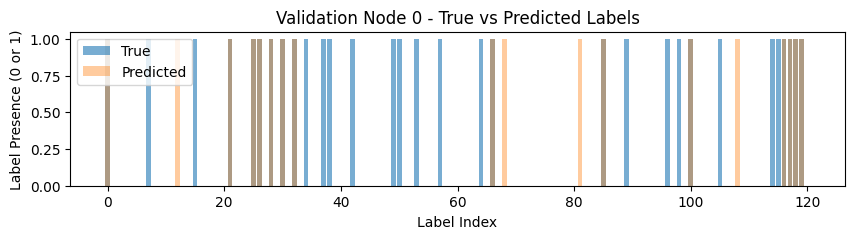

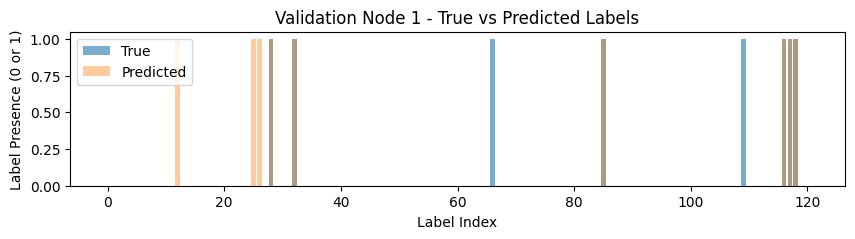

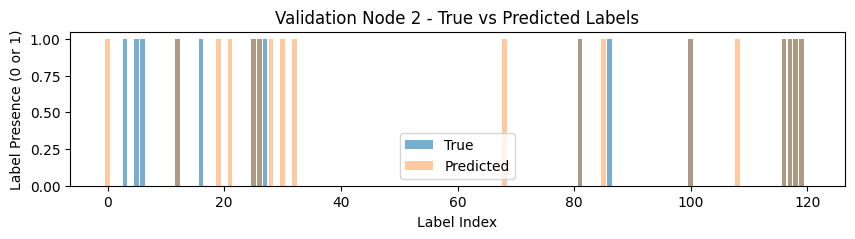

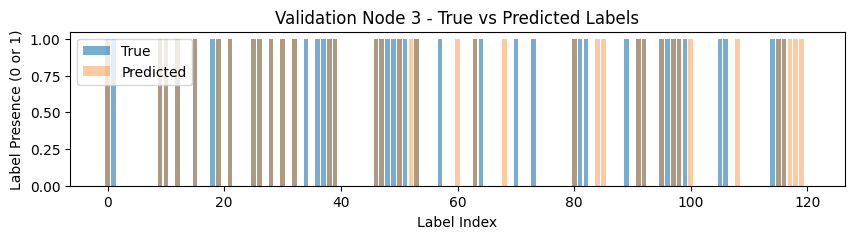

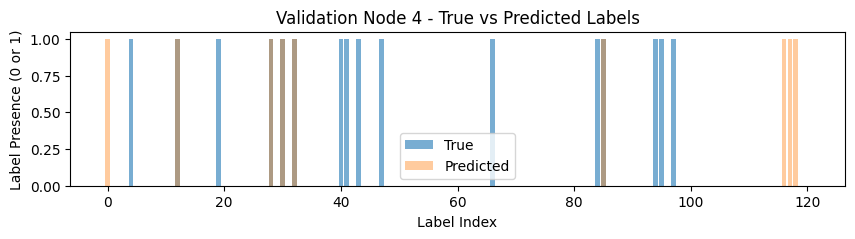

In [ ]:
# Switch model to eval mode
model.eval()

# Get first validation graph
sample = val_dataset[0].to(device)

# Predict
with torch.no_grad():
    pred = model(sample.x, sample.edge_index)
    pred_bin = (pred > 0.5).float().cpu()

# Plot true vs predicted labels for first 5 nodes
num_nodes_to_plot = 5
for i in range(num_nodes_to_plot):
    plt.figure(figsize=(10, 2))
    plt.bar(range(out_feats), sample.y[i].cpu(), alpha=0.6, label='True')
    plt.bar(range(out_feats), pred_bin[i], alpha=0.4, label='Predicted')
    plt.title(f"Validation Node {i} - True vs Predicted Labels")
    plt.xlabel("Label Index")
    plt.ylabel("Label Presence (0 or 1)")
    plt.legend()
    plt.show()
